# Optical Crosstalk in SPAD arrays


# Theory

Optical crosstalk is a interaction between pixels on the same 
array. When an avalanche is triggered on one pixel it emits 
secondary photons that can trigger another pixel on the same chip. 
This secondary photon emission is proportional to the avalanche current 
whose duration is typically < 20ns in SPADs using AQCs. Hence, when a
crosstalk event occurs, the second pixels is triggered with a delay
< 20ns. We can estimate the crosstalk by "coincidence counting",
that is counting the number of photons $C$ arriving in two pixels 
within a short time window $\Delta t$ (e.g. 25-50ns). 
The number of coincident events due to uncorrelated dark counts 
can be computed from Poisson statistics. Then, the number
of crosstalk events is simply the total coincidence counts minus
the coincidence due to uncorrelated counts. The crosstalk probability
is the number of coincidences divided by the total counts.

**Reference**:
- [Restelli JMO 2006](http://dx.doi.org/10.1080/09500340600790121).

## Poisson statistics

Given the random variable $X \sim {\rm Poiss}\{\Lambda\}$, 
where $\Lambda = \lambda\Delta t$. We ask, what is the probability
of having at least one count in a time window $\delta t$?

$$P\{X \ge 1\} = 1 - P\{X = 0\} = 1 - e^\Lambda 
\xrightarrow[\scriptstyle\Lambda\to0]{} \Lambda$$

Hence, for two random variables $X_A \sim {\rm Poiss}\{\Lambda_A\}$
and $X_B \sim {\rm Poiss}\{\Lambda_B\}$, the propbability of having
at least one count in each variable in a time $\Delta t$ is:

$$P\{X_A \ge 1\}P\{X_B \ge 1\} = (1 - e^{-\Lambda_A})(1 - e^{-\Lambda_B})
\approx (\lambda_A\Delta t)(\lambda_B\Delta t) 
\quad {\rm for}\quad\Delta t \ll \lambda^{-1}$$

In a measurement of duration $T$, number of "coincidences" $C_u$ is the number
of times both variables have at least one count in a window $\Delta t$

$$C_u = P\{X_A \ge 1\}P\{X_B \ge 1\} \frac{T}{\Delta t}
\approx \lambda_A\,\lambda_B\, T\,\,\Delta t 
\quad {\rm for}\quad\Delta t \ll \lambda^{-1}$$

## Crosstalk probability

Given a measurement of duration $T$, with total counts $N_A$ and $N_B$ in
pixels $A$ and $B$. If $C$ are the total number of coincidence in windows of 
duration $\Delta t$, then the coincidence $C_c$ due to crosstalk are:

\begin{equation}
C_c = C - C_u \qquad\qquad (1)
\end{equation}

where $C_u$ are the number of coincidences due to Poisson statistics, 
i.e. the coincidences we would have if the two pixels were uncorrelated.
 
\begin{equation}
C_u = \left[1 - \exp\left(-\frac{N_A - C_c}{T}\right)\right]
      \left[1 - \exp\left(-\frac{N_B - C_c}{T}\right)\right]
      \frac{T}{\Delta t}
\end{equation}

The expression of $C_u$ can be replaced eq. (1) and then solved for $C_c$ 
(a numerical iterative solution is straightforward).
For simplicity, we could assume $C_c \ll N_A,N_B$ obtaining:

\begin{equation}
C_u = \left[1 - \exp\left(-\frac{N_A}{T}\right)\right]
      \left[1 - \exp\left(-\frac{N_B}{T}\right)\right]
      \frac{T}{\Delta t}
\end{equation}

In either cases, the probability of crosstalk is:

\begin{equation}
P_c = \frac{C_c}{N_A + N_B - C_c}
\end{equation}

The counts $C_c$ are independetent events and thus are Poisson distributed.
The standard deviation of $C_c$ is then
${\rm Std}\{C_c\} = \sqrt{C_c}$, and the standard deviation of $P_c$ is:

\begin{equation}
{\rm Std}\{P_c\} = \frac{\sqrt{C_c}}{N_A + N_B - C_c}
\end{equation}


## Define functions

In [1]:
def coincidence_py(timestamps1, timestamps2):
    """Pure python coincidence counting."""
    coinc = 0
    i1, i2 = 0, 0
    while (i1 < timestamps1.size) and (i2 < timestamps2.size):
        if timestamps1[i1] == timestamps2[i2]:
            coinc += 1
            i1 += 1
            i2 += 1
        elif timestamps1[i1] > timestamps2[i2]:
            i2 += 1
        elif timestamps1[i1] < timestamps2[i2]:
            i1 += 1
    return coinc

In [2]:
%load_ext Cython

In [3]:
%%cython
cimport numpy as np

def coincidence(np.int64_t[:] timestamps1, np.int64_t[:] timestamps2):
    """Cython coincidence counting."""
    cdef np.int64_t coinc, i1, i2, size1, size2
    size1 = timestamps1.size
    size2 = timestamps2.size
    coinc = 0
    i1, i2 = 0, 0
    while i1 < size1 and i2 < size2:
        if timestamps1[i1] == timestamps2[i2]:
            coinc += 1
            i1 += 1
            i2 += 1
        elif timestamps1[i1] > timestamps2[i2]:
            i2 += 1
        elif timestamps1[i1] < timestamps2[i2]:
            i1 += 1
    return coinc

In [4]:
def crosstalk_probability(t1, t2, tol=1e-6, max_iter=100):
    """Estimate crosstalk probability between two pixels in a SPAD array.
    
    Given two input arrays of timestamps `t1` and `t2`, estimate 
    the crosstalk probability using Poisson statistics without 
    approximations.
    
    Arguments:
        t1, t2 (array of ints): arrays of timestamps from DCR measurements
            for the two pixels to be measured. Timestamps need to be 
            integers and coincidences are detected when values in the two 
            arrays are equal. These arrays need to be rescaled, if 
            coincidence need to be computed on a delta t larger than \
            a single timestamp unit.
        tol (float): tollerance for iterative equasion solution
        max_iter (int): max iterations used to solve the equation
        
    Returns:
        A 3-element tuple:
        - crosstalk probability
        - crosstalk probability standard deviation
        - number of iterations used for the estimation.
    """
    T = (max((t1.max(), t2.max())) - min((t1.min(), t2.min())))
    C = coincidence(t1, t2)
    
    # Find C_c by solving eq. (1) iteratively
    C_c, C_u_prev = 0, 0
    for i in range(max_iter):
        C_u = ((1 - np.exp(-(t1.size - C_c)/T)) * 
               (1 - np.exp(-(t2.size - C_c)/T)) * T)
        C_c = C - C_u
        if np.abs(C_u - C_u_prev) < tol:
            break
        C_u_prev = C_u
    
    P_c = C_c / (t1.size + t2.size - C_c)
    sigma = np.sqrt(C_c) / (t1.size + t2.size - C_c)
    return P_c, sigma, i

# Simulation

## Poisson processes

Here we simulate two poisson processes to check the the coincidences 
are, as predicted, equal to $C_u$.

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Simulation parameters:

In [6]:
λ_A = 1000       # cps
λ_B = 2000       # cps
T = 600          # s
delta_t = 50e-9  # s
P_c = 0.05

From theory, the number of coincidences are:

In [7]:
C_u = λ_A * λ_B * T * delta_t
C_u

60.0

In [8]:
np.sqrt(C_u)

7.745966692414834

Let's simulate timestamps for two uncorrelated Poisson processes:

In [9]:
dt = np.random.exponential(scale=1/λ_A, size=10**6)
dt.mean(), dt.sum()

(0.0010011925523826289, 1001.1925523826289)

In [10]:
np.random.seed(1)

t_A = np.cumsum(np.random.exponential(scale=1/λ_A, size=λ_A * T * 2))
assert t_A.max() > T
t_A = t_A[t_A < 600]
t_A = (t_A / delta_t).astype('int64')

t_B = np.cumsum(np.random.exponential(scale=1/λ_B, size=λ_B * T * 2))
assert t_B.max() > T
t_B = t_B[t_B < 600]
t_B = (t_B / delta_t).astype('int64')

The empirical coincidences are:

In [11]:
C_u_sim = coincidence(t_A, t_B)
C_u_sim

62

In [12]:
assert C_u - 3*np.sqrt(C_u) < C_u_sim < C_u + 3*np.sqrt(C_u)

Let's repeat the simulation $N$ times to be sure that the 
estimated coincidence falls within the espected error range
all the times:

In [13]:
N = 500
fail = 0
for _ in range(N):
    t_A = np.cumsum(np.random.exponential(scale=1/λ_A, size=λ_A * T * 2))
    assert t_A.max() > T
    t_A = t_A[t_A < T]
    t_A = (t_A / delta_t).astype('int64')

    t_B = np.cumsum(np.random.exponential(scale=1/λ_B, size=λ_B * T * 2))
    assert t_B.max() > T
    t_B = t_B[t_B < T]
    t_B = (t_B / delta_t).astype('int64')
    
    C_u_sim = coincidence(t_A, t_B)
    if C_u < C_u_sim - 3*np.sqrt(C_u_sim) or C_u > C_u_sim + 3*np.sqrt(C_u_sim):
        fail += 1

print('>>> In %d simulations, the number of coincincence was outside the error range %d times' 
      % (N, fail/N))

>>> In 500 simulations, the number of coincincence was outside the error range 0 times


For further information of confidence intervals for Poisson distribution
estimators see:

- Patil & Kulkarni. *Statistical Journal* 10(2) pp211–227(2012). 
  COMPARISON OF CONFIDENCE INTERVALS FOR THE POISSON MEAN: SOME NEW ASPECTS. 
  [[PDF]](https://www.ine.pt/revstat/pdf/rs120203.pdf) 

## Optical crosstalk

Here we simulate two Poisson processes plus crosstalk, to check 
that the estimated crosstalk is consistent with the ground truth.

In [14]:
λ_A = 1000       # cps
λ_B = 1550       # cps
T = 1200         # s
delta_t = 50e-9  # s
P_c = 0.1

In [15]:
np.random.seed(1)

In [16]:
t_A = np.cumsum(np.random.exponential(scale=1/λ_A, size=λ_A * T * 2))
assert t_A.max() > T
t_A = t_A[t_A < 600]
t_A = (t_A / delta_t).astype('int64')
t_ct_AB = t_A[np.random.rand(t_A.size) <= P_c]

t_B = np.cumsum(np.random.exponential(scale=1/λ_B, size=λ_B * T * 2))
assert t_B.max() > T
t_B = t_B[t_B < 600]
t_B = (t_B / delta_t).astype('int64')
t_ct_BA = t_B[np.random.rand(t_B.size) <= P_c]

t_B = np.hstack([t_B, t_ct_AB])
t_B.sort()
t_A = np.hstack([t_A, t_ct_BA])
t_A.sort()

In [17]:
P_c_est, P_c_err, i = crosstalk_probability(t_A, t_B, delta_t)
P_c_est*100, P_c_err*300, i

(9.9967084810755544, 0.076659160092492767, 4)

Let's repeat the simulation $N$ times to obtain a distribution
of estimated crosstalk values:

In [21]:
λ_A = 1000       # cps
λ_B = 300       # cps
T = 1200         # s
delta_t = 50e-9  # s
P_c = 0.05

In [22]:
N = 100
P = []
I = 0
for _ in range(N):
    t_A = np.cumsum(np.random.exponential(scale=1/λ_A, size=λ_A * T * 2))
    assert t_A.max() > T
    t_A = t_A[t_A < T]
    t_A = (t_A / delta_t).astype('int64')
    t_ct_AB = t_A[np.random.rand(t_A.size) <= P_c]

    t_B = np.cumsum(np.random.exponential(scale=1/λ_B, size=λ_B * T * 2))
    assert t_B.max() > T
    t_B = t_B[t_B < T]
    t_B = (t_B / delta_t).astype('int64')
    t_ct_BA = t_B[np.random.rand(t_B.size) <= P_c]

    t_B = np.hstack([t_B, t_ct_AB])
    t_B.sort()
    t_A = np.hstack([t_A, t_ct_BA])
    t_A.sort()
    
    P_c_est, P_c_err, i = crosstalk_probability(t_A, t_B)
    I += i
    P.append(P_c_est*100)
I/N

3.0

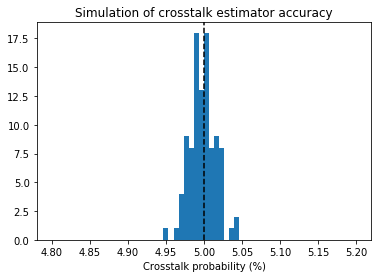

In [23]:
plt.hist(P, range=(96*P_c, 104*P_c), bins=60, label='Estimator');
plt.axvline(P_c*100, ls='--', color='k', label='True value')
plt.xlabel('Crosstalk probability (%)')
plt.title('Simulation of crosstalk estimator accuracy');

> **NOTE** The crosstalk estimator is well centered around the true value.